# Milestone 2: baseline models
___

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models
from importlib import reload
reload(import_preprocess)
reload(baseline_models)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, RuleBasedClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

In [35]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


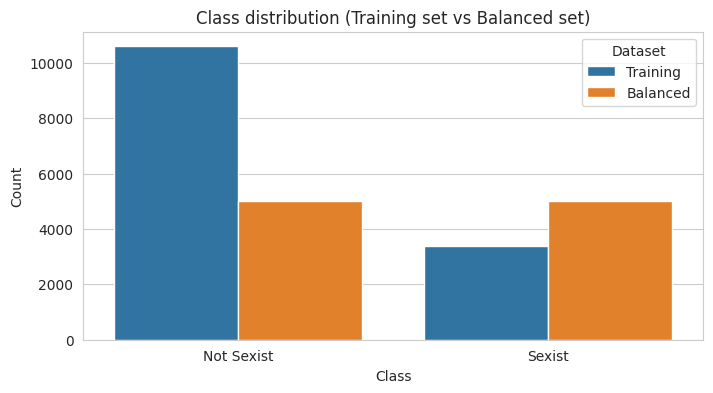

In [36]:
plot_data = pd.DataFrame({
    'Class': ['Not Sexist', 'Sexist'],
    'Training': [y_train.count('not sexist'), y_train.count('sexist')],
    'Balanced': [y_balanced.count('not sexist'), y_balanced.count('sexist')]
})
plot_data_melted = plot_data.melt(id_vars='Class', var_name='Dataset', value_name='Count')
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_data_melted)
plt.title('Class distribution (Training set vs Balanced set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [37]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



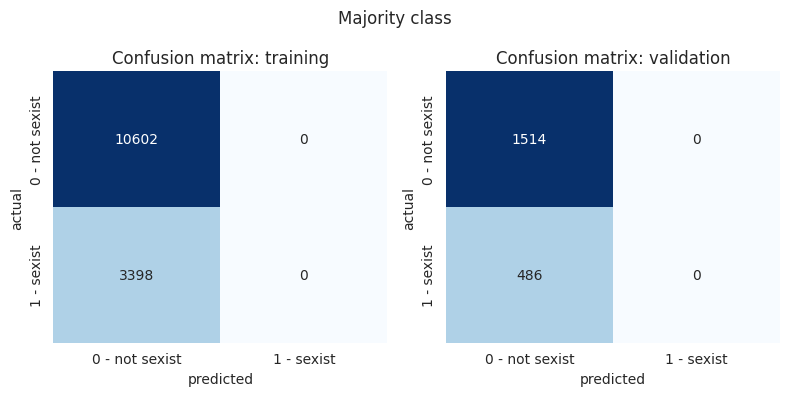

In [38]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="Majority class")
for res_x in res:
    results.loc[len(results)] = res_x

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.5000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



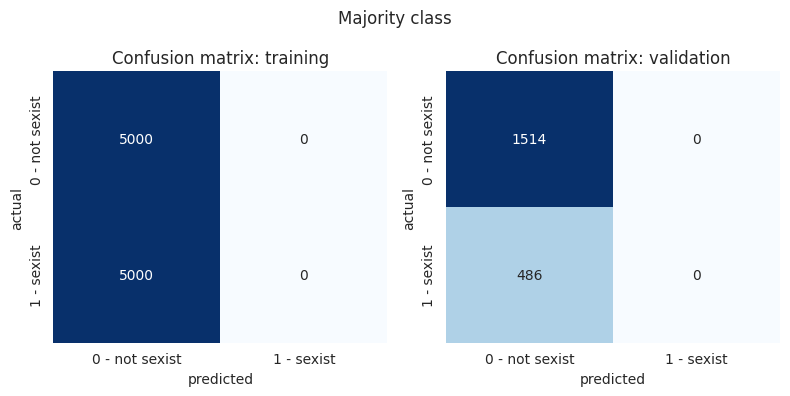

In [39]:
majority_class_classifier_bal = MajorityClassClassifier()
majority_class_classifier_bal.train(None, y_balanced, None, None)
print(f"Majority class: {majority_class_classifier_bal.majority_class}\n")

res = majority_class_classifier_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="Majority class")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

2. regex classifier (rule-based)

########################################

Metrics for training
accuracy: 0.7164
balanced accuracy: 0.5732
precision: 0.3890
recall: 0.2949

########################################

Metrics for validation
accuracy: 0.7075
balanced accuracy: 0.5630
precision: 0.3673
recall: 0.2819

########################################



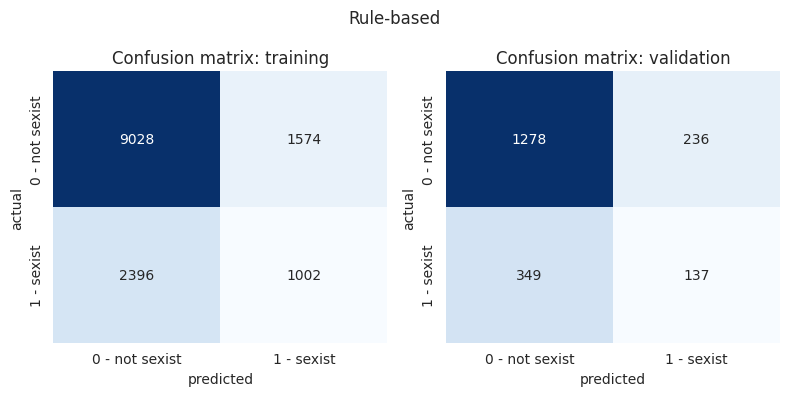

In [40]:
patterns = [
    r"\b(slut|bitch|fuck|fucking|sex)\b",
    r"\b(she has|she has to|she must|she shouldn't|women have to|women must|women shouldn't)\b",
    r"\b(hate|die)\b"
]

regex_classifier = RuleBasedClassifier(patterns)
res = regex_classifier.evaluate({"training": S_train, "validation": S_val}, [y_train, y_val], model_name="Rule-based")
for res_x in res:
    results.loc[len(results)] = res_x

3. Naive Bayes (NB)

########################################

Metrics for training
accuracy: 0.8619
balanced accuracy: 0.7942
precision: 0.7412
recall: 0.6624

########################################

Metrics for validation
accuracy: 0.8095
balanced accuracy: 0.7128
precision: 0.6296
recall: 0.5247

########################################



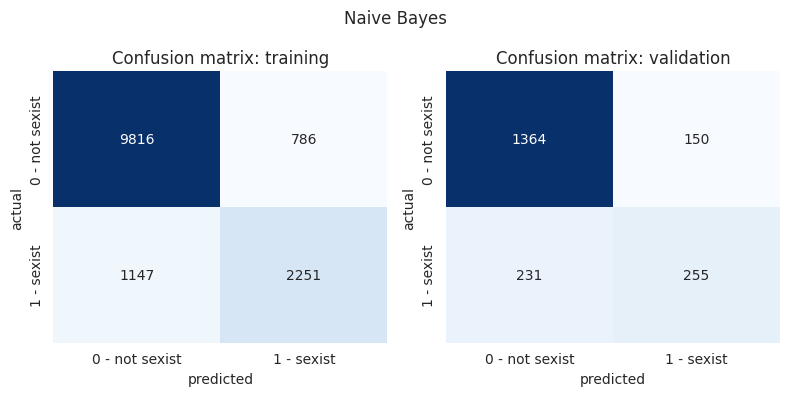

In [41]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x

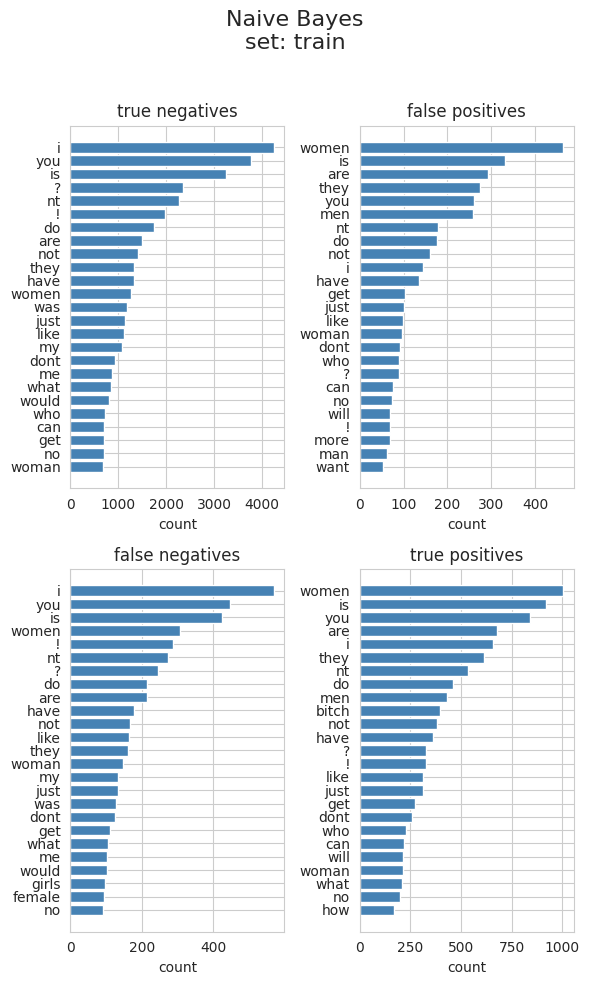

In [42]:
naive_bayes_classifier.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

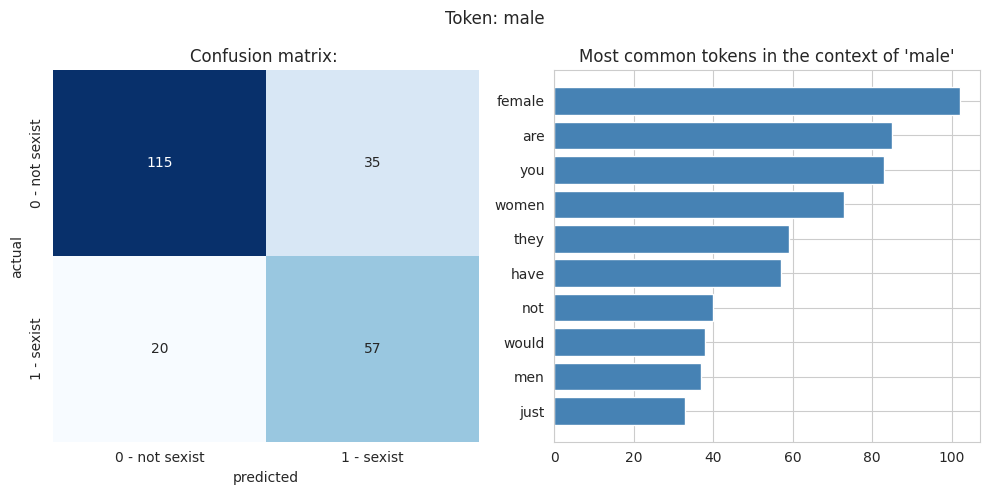

Examples:
Label: not sexist
It found that the male student accused the female student of sexual assault as âa tactical maneuver and in bad faith.â Belieeeeeve the **female** victim!

Label: sexist
Male dolphin wakes up next to female whale. "Aww man! I thought you were just a fat chick! You're a whale?!" (My apologies to women who are a little heavier than average, I adore you.) ( no really I f-ing ADORE you.)

Label: sexist
And there we have the root cause of the "white male problem"... white women are to blame

Label: sexist
Sheâs probably on her back getting her legs stretched out and getting fucked by a genetically superior male while sheâs text you for her own amusement. Sorry man, itâs over

Label: not sexist
like almost all sports the main events are open to both genders but they are utterly male dominated so all sports have female only events that exist to give women money fame and medals too



In [43]:
naive_bayes_classifier.get_context_for_token("male", X_train_bow, y_train, X_train, S_train, no_examples=5, return_contexts=False)

In [44]:
top_tn_tokens, top_fp_tokens, top_fn_tokens, top_tp_tokens = \
    naive_bayes_classifier.qualitative_analysis_top_tokens(
        X_train, X_train_bow, y_train, set_type="train", 
        model_name="Naive Bayes", plot=False, top_n=50)

########################################

Metrics for training
accuracy: 0.8264
balanced accuracy: 0.8264
precision: 0.8130
recall: 0.8478

########################################

Metrics for validation
accuracy: 0.7235
balanced accuracy: 0.7021
precision: 0.4528
recall: 0.6605

########################################



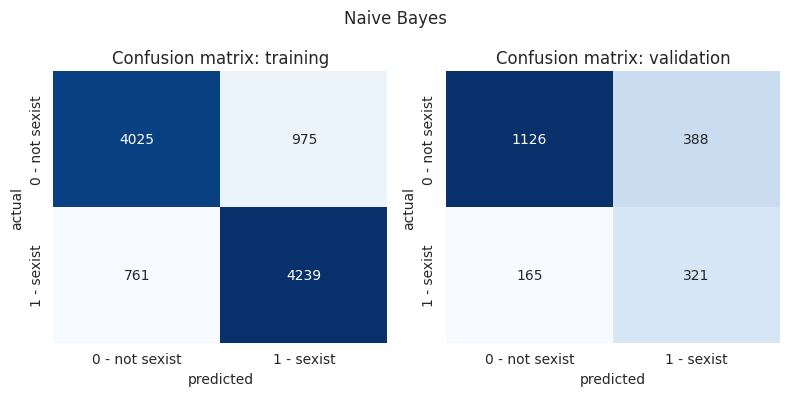

In [45]:
X_train_balanced_bow, X_val_balanced_bow, X_test_balanced_bow, X_train_val_balanced_bow, feature_names = import_preprocess.create_bow_representation(balanced=True)

naive_bayes_classifier_bal = NaiveBayesClassifier()
naive_bayes_classifier_bal.train(X_train_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

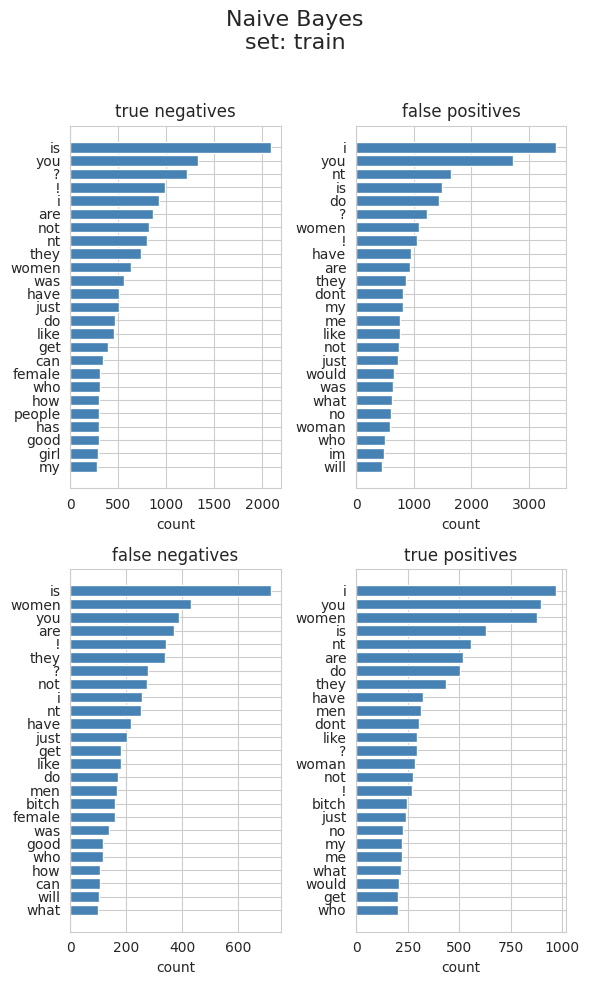

In [46]:
naive_bayes_classifier_bal.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

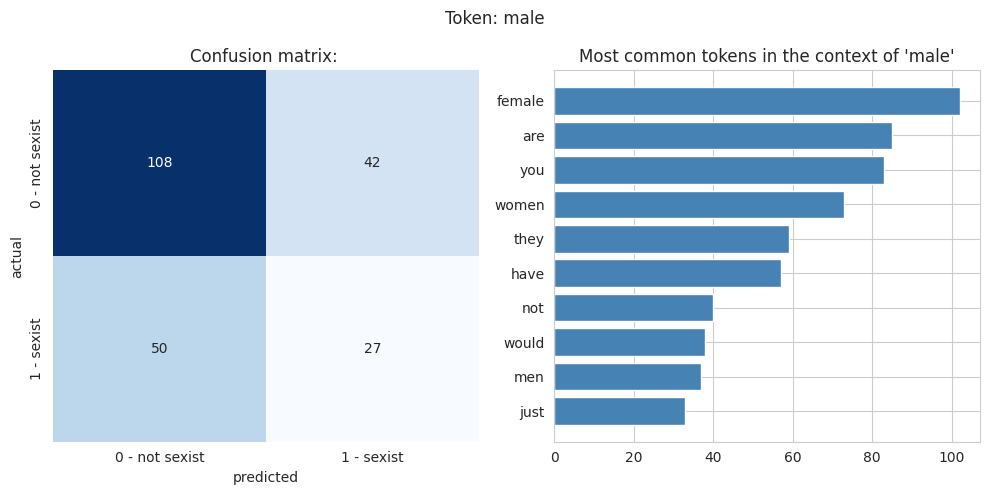

Examples:
Label: not sexist
It found that the male student accused the female student of sexual assault as âa tactical maneuver and in bad faith.â Belieeeeeve the **female** victim!

Label: sexist
Male dolphin wakes up next to female whale. "Aww man! I thought you were just a fat chick! You're a whale?!" (My apologies to women who are a little heavier than average, I adore you.) ( no really I f-ing ADORE you.)

Label: sexist
And there we have the root cause of the "white male problem"... white women are to blame

Label: sexist
Sheâs probably on her back getting her legs stretched out and getting fucked by a genetically superior male while sheâs text you for her own amusement. Sorry man, itâs over

Label: not sexist
like almost all sports the main events are open to both genders but they are utterly male dominated so all sports have female only events that exist to give women money fame and medals too



In [47]:
naive_bayes_classifier_bal.get_context_for_token("male", X_train_bow, y_train, X_train, S_train, no_examples=5, return_contexts=False)

4. Logisitic Regression

########################################

Metrics for training
accuracy: 0.8934
balanced accuracy: 0.8052
precision: 0.8964
recall: 0.6339

########################################

Metrics for validation
accuracy: 0.8305
balanced accuracy: 0.7092
precision: 0.7348
recall: 0.4733

########################################



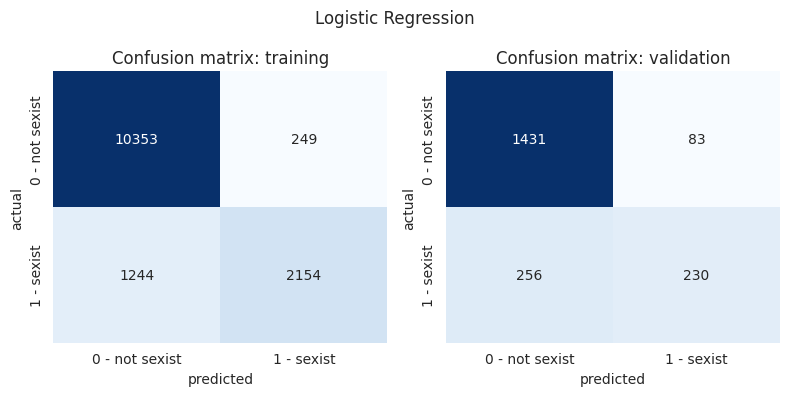

In [48]:
log_reg_classifier = LogisticRegression()
log_reg_classifier.train(X_train_bow, y_train, None, None)

res = log_reg_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Logistic Regression")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.9178
balanced accuracy: 0.9178
precision: 0.9279
recall: 0.9060

########################################

Metrics for validation
accuracy: 0.6080
balanced accuracy: 0.5490
precision: 0.2931
recall: 0.4342

########################################



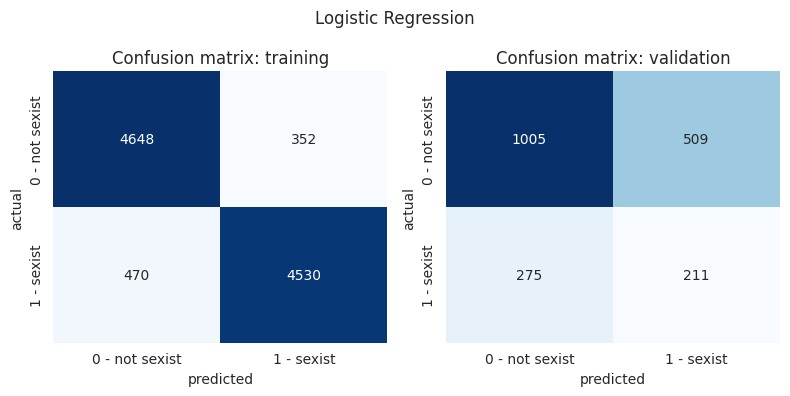

In [49]:
log_reg_classifier_bal = LogisticRegression()
log_reg_classifier_bal.train(X_train_balanced_bow, y_balanced, None, None)

res = log_reg_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Logistic Regression")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (using BoW representation)

[0]	train-logloss:0.52937	eval-logloss:0.53489
[1]	train-logloss:0.50975	eval-logloss:0.51887
[2]	train-logloss:0.49416	eval-logloss:0.50663
[3]	train-logloss:0.48118	eval-logloss:0.49671
[4]	train-logloss:0.46994	eval-logloss:0.48861
[5]	train-logloss:0.46077	eval-logloss:0.48165
[6]	train-logloss:0.45331	eval-logloss:0.47542
[7]	train-logloss:0.44618	eval-logloss:0.47046
[8]	train-logloss:0.44031	eval-logloss:0.46619
[9]	train-logloss:0.43467	eval-logloss:0.46229
[10]	train-logloss:0.43020	eval-logloss:0.45909
[11]	train-logloss:0.42613	eval-logloss:0.45672
[12]	train-logloss:0.42236	eval-logloss:0.45474
[13]	train-logloss:0.41823	eval-logloss:0.45253
[14]	train-logloss:0.41514	eval-logloss:0.45026
[15]	train-logloss:0.41209	eval-logloss:0.44859
[16]	train-logloss:0.40948	eval-logloss:0.44689
[17]	train-logloss:0.40657	eval-logloss:0.44544
[18]	train-logloss:0.40448	eval-logloss:0.44370
[19]	train-logloss:0.40261	eval-logloss:0.44258
[20]	train-logloss:0.40053	eval-logloss:0.44125
[2

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:49:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	train-logloss:0.39526	eval-logloss:0.43739
[24]	train-logloss:0.39383	eval-logloss:0.43642
[25]	train-logloss:0.39211	eval-logloss:0.43579
[26]	train-logloss:0.39071	eval-logloss:0.43479
[27]	train-logloss:0.38941	eval-logloss:0.43397
[28]	train-logloss:0.38792	eval-logloss:0.43289
[29]	train-logloss:0.38679	eval-logloss:0.43173
[30]	train-logloss:0.38572	eval-logloss:0.43145
[31]	train-logloss:0.38417	eval-logloss:0.43102
[32]	train-logloss:0.38318	eval-logloss:0.43008
[33]	train-logloss:0.38220	eval-logloss:0.42899
[34]	train-logloss:0.38043	eval-logloss:0.42845
[35]	train-logloss:0.37903	eval-logloss:0.42775
[36]	train-logloss:0.37784	eval-logloss:0.42706
[37]	train-logloss:0.37641	eval-logloss:0.42667
[38]	train-logloss:0.37552	eval-logloss:0.42639
[39]	train-logloss:0.37432	eval-logloss:0.42534
[40]	train-logloss:0.37353	eval-logloss:0.42477
[41]	train-logloss:0.37233	eval-logloss:0.42431
[42]	train-logloss:0.37153	eval-logloss:0.42389
[43]	train-logloss:0.37066	eval-logloss:

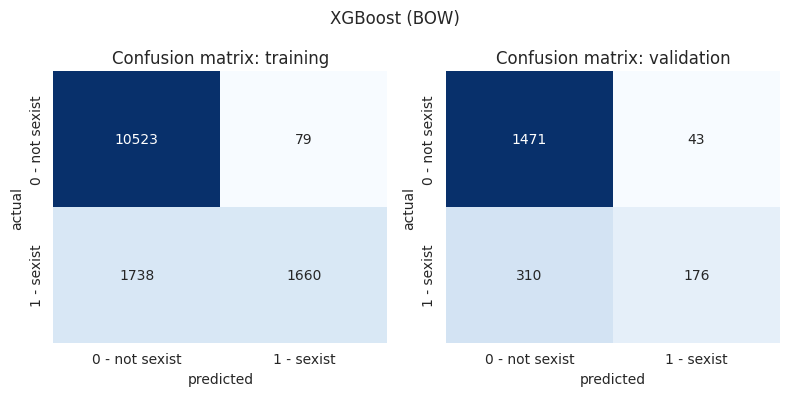

In [50]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66552	eval-logloss:0.66937
[1]	train-logloss:0.64314	eval-logloss:0.64997
[2]	train-logloss:0.62439	eval-logloss:0.63428
[3]	train-logloss:0.60845	eval-logloss:0.62021
[4]	train-logloss:0.59485	eval-logloss:0.60878
[5]	train-logloss:0.58311	eval-logloss:0.59900
[6]	train-logloss:0.57246	eval-logloss:0.58984
[7]	train-logloss:0.56317	eval-logloss:0.58197
[8]	train-logloss:0.55475	eval-logloss:0.57508
[9]	train-logloss:0.54718	eval-logloss:0.56873
[10]	train-logloss:0.54038	eval-logloss:0.56274
[11]	train-logloss:0.53464	eval-logloss:0.55901


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:49:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	train-logloss:0.52901	eval-logloss:0.55476
[13]	train-logloss:0.52414	eval-logloss:0.55098
[14]	train-logloss:0.51897	eval-logloss:0.54761
[15]	train-logloss:0.51439	eval-logloss:0.54481
[16]	train-logloss:0.51090	eval-logloss:0.54122
[17]	train-logloss:0.50790	eval-logloss:0.53822
[18]	train-logloss:0.50485	eval-logloss:0.53601
[19]	train-logloss:0.50211	eval-logloss:0.53417
[20]	train-logloss:0.49960	eval-logloss:0.53183
[21]	train-logloss:0.49519	eval-logloss:0.52944
[22]	train-logloss:0.49283	eval-logloss:0.52785
[23]	train-logloss:0.48979	eval-logloss:0.52639
[24]	train-logloss:0.48792	eval-logloss:0.52442
[25]	train-logloss:0.48542	eval-logloss:0.52287
[26]	train-logloss:0.48341	eval-logloss:0.52132
[27]	train-logloss:0.48167	eval-logloss:0.52028
[28]	train-logloss:0.47885	eval-logloss:0.51918
[29]	train-logloss:0.47708	eval-logloss:0.51806
[30]	train-logloss:0.47476	eval-logloss:0.51642
[31]	train-logloss:0.47252	eval-logloss:0.51521
[32]	train-logloss:0.47042	eval-logloss:

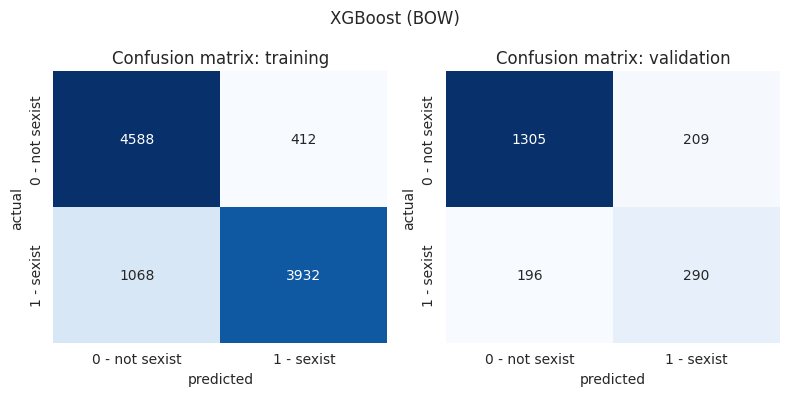

In [51]:
xg_boost_bow_bal = XGBoostClassifier()
xg_boost_bow_bal.train(X_train_balanced_bow, y_balanced, X_val_balanced_bow, y_val)

res = xg_boost_bow_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (TF-IDF representation)

[0]	train-logloss:0.52887	eval-logloss:0.53481
[1]	train-logloss:0.50866	eval-logloss:0.51893


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:49:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	train-logloss:0.49211	eval-logloss:0.50632
[3]	train-logloss:0.47822	eval-logloss:0.49579
[4]	train-logloss:0.46689	eval-logloss:0.48736
[5]	train-logloss:0.45720	eval-logloss:0.48059
[6]	train-logloss:0.44937	eval-logloss:0.47479
[7]	train-logloss:0.44192	eval-logloss:0.47042
[8]	train-logloss:0.43481	eval-logloss:0.46648
[9]	train-logloss:0.42906	eval-logloss:0.46259
[10]	train-logloss:0.42445	eval-logloss:0.45949
[11]	train-logloss:0.41981	eval-logloss:0.45674
[12]	train-logloss:0.41566	eval-logloss:0.45433
[13]	train-logloss:0.41195	eval-logloss:0.45246
[14]	train-logloss:0.40822	eval-logloss:0.45080
[15]	train-logloss:0.40494	eval-logloss:0.44932
[16]	train-logloss:0.40223	eval-logloss:0.44767
[17]	train-logloss:0.39943	eval-logloss:0.44622
[18]	train-logloss:0.39662	eval-logloss:0.44455
[19]	train-logloss:0.39396	eval-logloss:0.44357
[20]	train-logloss:0.39131	eval-logloss:0.44269
[21]	train-logloss:0.38782	eval-logloss:0.44153
[22]	train-logloss:0.38615	eval-logloss:0.44021


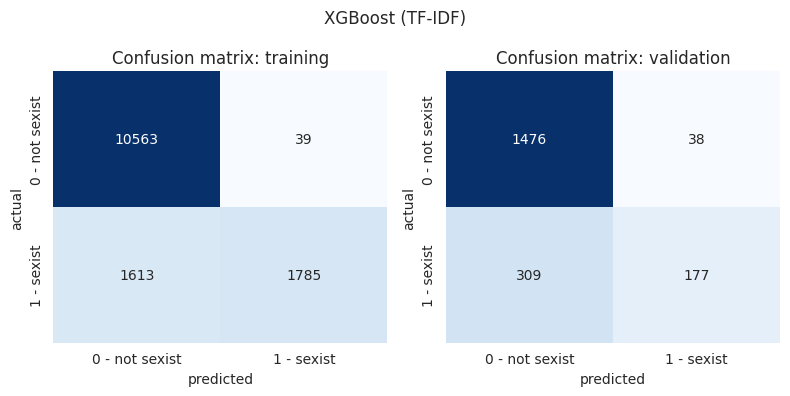

In [52]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, X_train_val_tfidf, feature_names = import_preprocess.create_tfidf_representation()

xg_boost_tfidf = XGBoostClassifier()
xg_boost_tfidf.train(X_train_tfidf, y_train, X_val_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_tfidf, "validation": X_val_tfidf}, [y_train, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66493	eval-logloss:0.66985
[1]	train-logloss:0.64199	eval-logloss:0.65025


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:49:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	train-logloss:0.62313	eval-logloss:0.63434
[3]	train-logloss:0.60671	eval-logloss:0.62087
[4]	train-logloss:0.59194	eval-logloss:0.60860
[5]	train-logloss:0.57926	eval-logloss:0.59773
[6]	train-logloss:0.56822	eval-logloss:0.58890
[7]	train-logloss:0.55778	eval-logloss:0.58064
[8]	train-logloss:0.54926	eval-logloss:0.57365
[9]	train-logloss:0.54213	eval-logloss:0.56786
[10]	train-logloss:0.53570	eval-logloss:0.56249
[11]	train-logloss:0.52877	eval-logloss:0.55754
[12]	train-logloss:0.52292	eval-logloss:0.55294
[13]	train-logloss:0.51828	eval-logloss:0.54902
[14]	train-logloss:0.51232	eval-logloss:0.54568
[15]	train-logloss:0.50780	eval-logloss:0.54243
[16]	train-logloss:0.50363	eval-logloss:0.53948
[17]	train-logloss:0.49827	eval-logloss:0.53664
[18]	train-logloss:0.49373	eval-logloss:0.53428
[19]	train-logloss:0.49054	eval-logloss:0.53217
[20]	train-logloss:0.48715	eval-logloss:0.53053
[21]	train-logloss:0.48452	eval-logloss:0.52797
[22]	train-logloss:0.48151	eval-logloss:0.52646


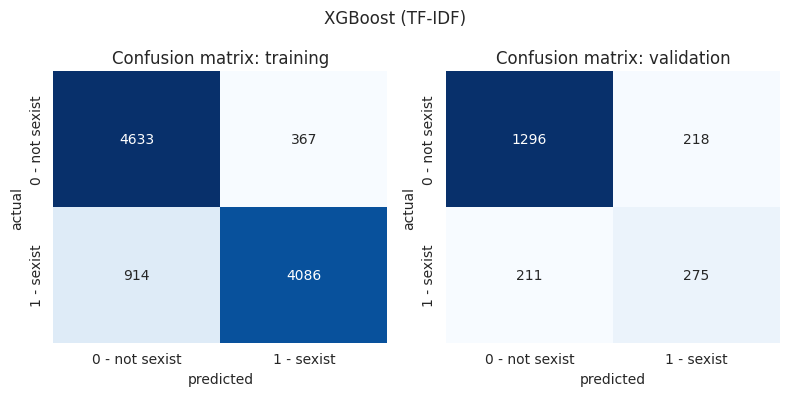

In [53]:
X_train_balanced_tfidf, X_val_balanced_tfidf, X_test_balanced_tfidf, X_train_val_balanced_tfidf, feature_names = import_preprocess.create_tfidf_representation(balanced=True)

xg_boost_tfidf_bal = XGBoostClassifier()
xg_boost_tfidf_bal.train(X_train_balanced_tfidf, y_balanced, X_val_balanced_tfidf, y_val)

res = xg_boost_tfidf_bal.evaluate({"training": X_train_balanced_tfidf, "validation": X_val_balanced_tfidf}, [y_balanced, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

#### b) DL baseline models

1. LSTM

In [54]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x

Epoch 1/10
367/438 [========================>.....] - ETA: 0s - loss: 0.5449 - accuracy: 0.7570

KeyboardInterrupt: 

438/438 [==============================] - 1s 3ms/step


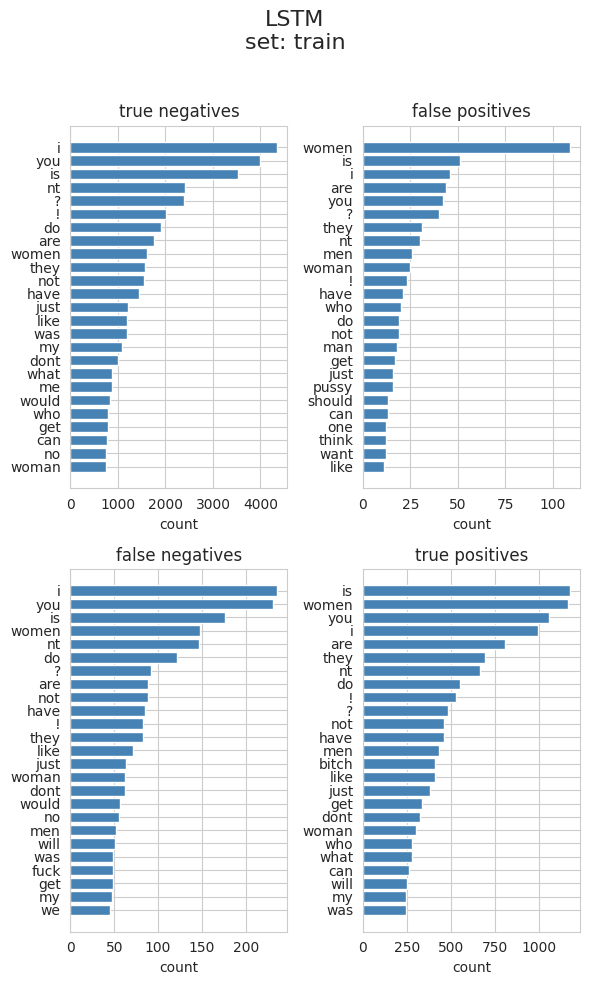

In [22]:
rnn.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

438/438 [==============================] - 1s 3ms/step


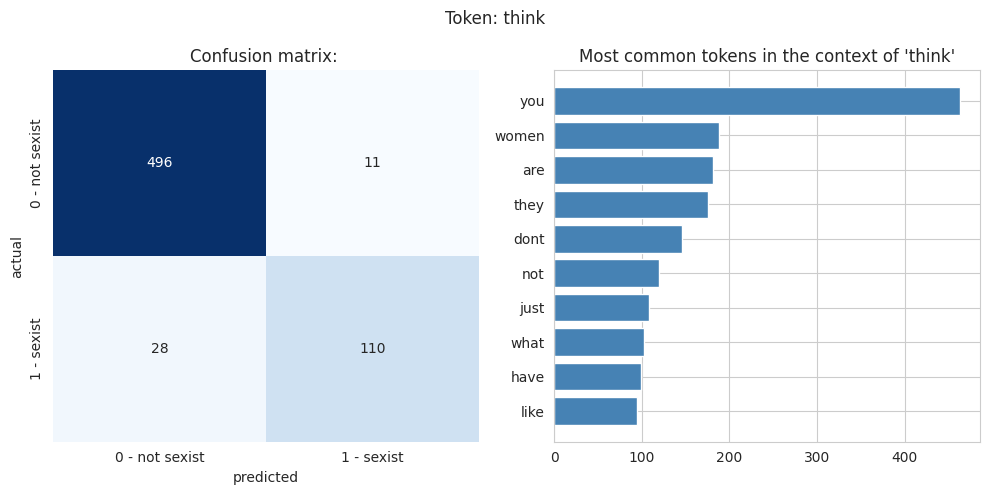

Examples:
Label: not sexist
But "he" looks very much was born in a female body and did nothing to change that. I think if "he" is attractive enough of a female, she would definitely want to have sex with him.

Label: not sexist
You think Gen Z is going to be bad, just wait for the Millenial's kids to hit college age

Label: not sexist
I actually don't think there is anything wrong with the ad. She may have done extraordinarily, but that does not reflect poorly on men nor well upon women. It just means she is extraordinary, each sex has some extraordinary people.

Label: not sexist
sounds like youâre still living in the 1950s. and maybe think about why women have to rest so much while pregnant maybe even ask your mother iâm sure sheâd be disappointed

Label: not sexist
Theyâll do it anyway. I think itâs not uncommon for women to get assaulted when theyâre sick and medicated.



In [23]:
rnn.get_context_for_token("think", X_train, y_train, X_train, S_train, no_examples=5, return_contexts=False)

Epoch 1/10
313/313 [==============================] - 5s 13ms/step - loss: 0.6937 - accuracy: 0.4975 - val_loss: 0.6832 - val_accuracy: 0.7565
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 0.6935 - accuracy: 0.5043 - val_loss: 0.6917 - val_accuracy: 0.7545
Epoch 3/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6968 - val_accuracy: 0.2430
Epoch 4/10
313/313 [==============================] - 4s 13ms/step - loss: 0.6934 - accuracy: 0.4996 - val_loss: 0.6964 - val_accuracy: 0.2430
Epoch 5/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6933 - accuracy: 0.5024 - val_loss: 0.6855 - val_accuracy: 0.7570
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6933 - accuracy: 0.4984 - val_loss: 0.6917 - val_accuracy: 0.7550
Epoch 7/10
313/313 [==============================] - 4s 12ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6799 - val_accuracy: 0.7120

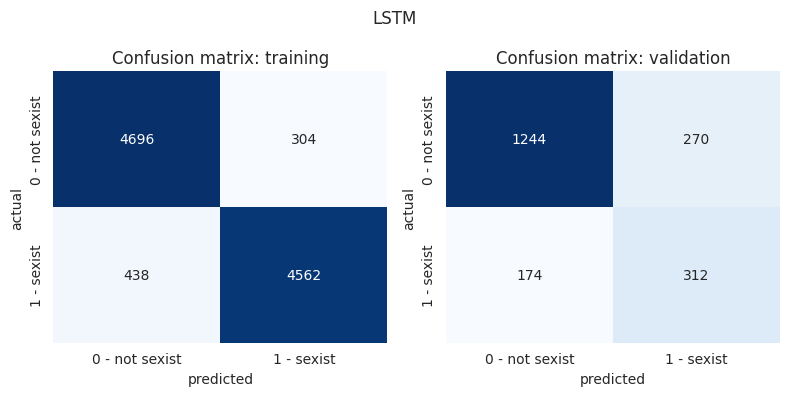

In [24]:
rnn_bal = LSTM_Model()
rnn_bal.train(X_balanced, y_balanced, X_val, y_val)
res = rnn_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

438/438 [==============================] - 1s 3ms/step


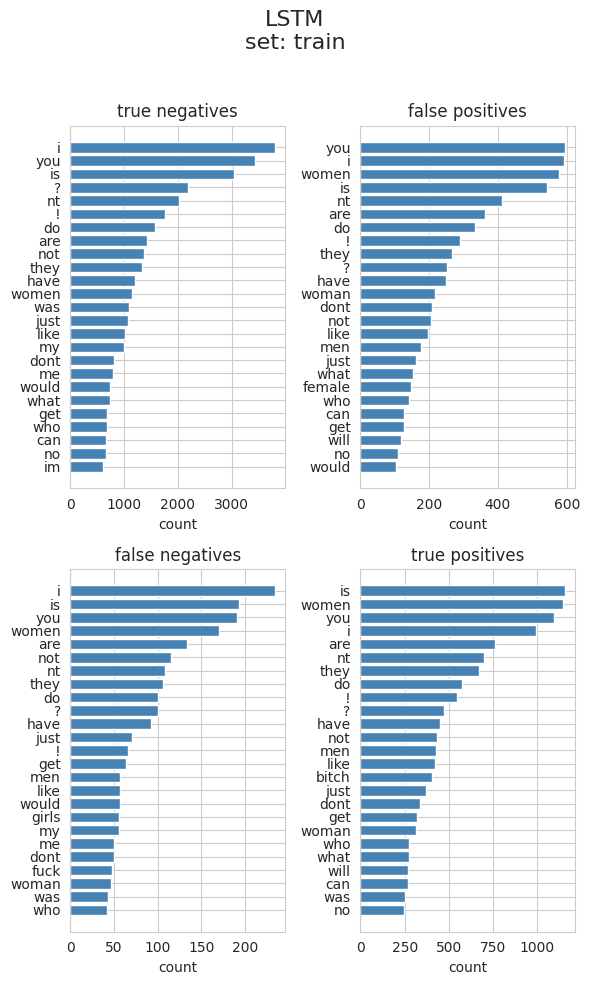

In [25]:
rnn_bal.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

438/438 [==============================] - 2s 4ms/step


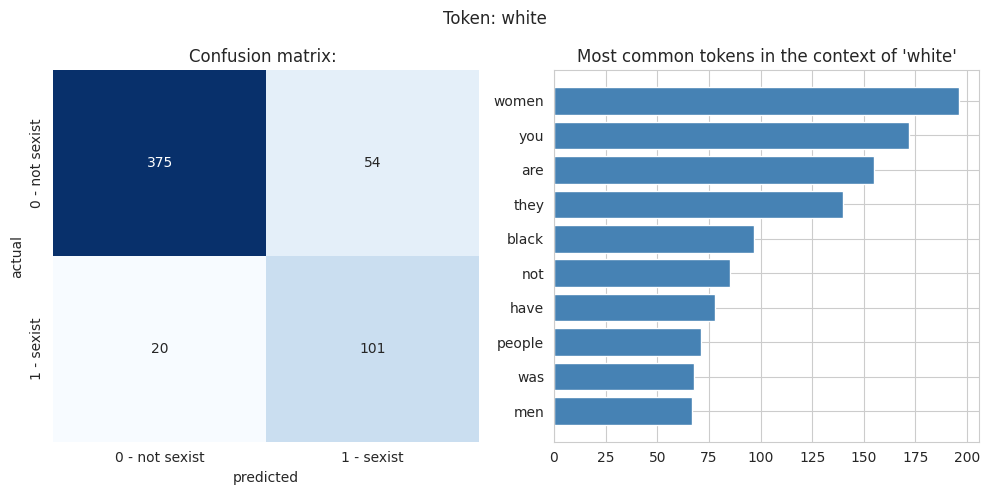

Examples:
Label: not sexist
Globalist groupie Twatter hates white people... but they love that Sharia Law, because it offers âlegalâ rape of women and children.

Label: not sexist
see also: Apple's former diversity officer who was a black woman, says a group of white men could be diverse due to different life experiences, then gets replaced by a white woman This would turn any person insane, holy fuck.

Label: not sexist
As if white men don't commit more violent crime than black women?

Label: not sexist
Feminism has destroyed all demographics except for upper middle class white American women.

Label: not sexist
Always one in the crowd, see those two little white specs right of the shack, dead birds. Generating juice at the expense of wild life, and it's not even a pitcher of juice at that.



In [26]:
rnn_bal.get_context_for_token("white", X_train, y_train, X_train, S_train, no_examples=5, return_contexts=False)

## Results

In [27]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.757286,0.500000,0.000000,0.000000
1,Majority class,validation,0.757000,0.500000,0.000000,0.000000
2,Rule-based,training,0.716429,0.573208,0.388975,0.294879
3,Rule-based,validation,0.707500,0.563007,0.367292,0.281893
4,Naive Bayes,training,0.861929,0.794156,0.741192,0.662448
5,Naive Bayes,validation,0.809500,0.712808,0.629630,0.524691
6,Logistic Regression,training,0.893357,0.805208,0.896380,0.633902
7,Logistic Regression,validation,0.830500,0.709215,0.734824,0.473251
8,XGBoost (BOW),training,0.870214,0.740536,0.954572,0.488523
9,XGBoost (BOW),validation,0.823500,0.666869,0.803653,0.362140


In [28]:
balanced_results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.5000,0.500000,0.000000,0.000000
1,Majority class,validation,0.7570,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.8298,0.829800,0.818217,0.848000
3,Naive Bayes,validation,0.7065,0.682498,0.429764,0.635802
4,Logistic Regression,training,0.9161,0.916100,0.928351,0.901800
5,Logistic Regression,validation,0.5550,0.516768,0.257794,0.442387
6,XGBoost (BOW),training,0.8448,0.844800,0.888814,0.788200
7,XGBoost (BOW),validation,0.7845,0.717252,0.553398,0.586420
8,XGBoost (TF-IDF),training,0.8587,0.858700,0.903306,0.803400
9,XGBoost (TF-IDF),validation,0.7805,0.711117,0.545809,0.576132


In [29]:
models_dict = {
    "Majority Class": majority_class_classifier,
    "Naive Bayes": naive_bayes_classifier,
    "Logistic Regression": log_reg_classifier,
    "XGBoost (BOW)": xg_boost_bow,
    "LSTM": rnn
}

predictions = get_all_predictions(models_dict, X_val[1], X_val_bow[1], y_val[1])

1/1 [==============================] - 0s 12ms/step


In [30]:
predictions

{'true': 'not sexist',
 'Majority Class': ['not sexist'],
 'Naive Bayes': array(['not sexist'], dtype='<U10'),
 'Logistic Regression': array(['not sexist'], dtype='<U10'),
 'XGBoost (BOW)': ['not sexist'],
 'LSTM': 'sexist'}

In [31]:
y_pred = rnn.predict(X_val)
y_pred = convert_labels_to_string(y_pred)
y_val = y_val if isinstance(y_val[0], str) else convert_labels_to_string(y_val)

false_negative_indices = [i for i in range(len(X_val)) if y_val[i] == 'sexist' and y_pred[i] == 'not sexist']
false_negative_sentences = [S_val[i] for i in false_negative_indices]
false_negative_sentences

63/63 [==============================] - 0s 3ms/step


['I agree with that but at the same time I know myself well enough to say I canâ\x80\x99t love a woman. The minute she begins to hit the wall and some hotter, younger women enters the picture, itâ\x80\x99s time for impulse control because Iâ\x80\x99m going to want that.',
 "aim for the head so she dosn't come back",
 "This guys gonna have a great time in the barracks. If they don't know who he is, they will the first time he takes a communal shower. Christ, the women Marines will even be giving him shit. Ooorah! Fuckin-A.",
 'until she\'s been around me long enough through real life situations where I can actually see who she really is Like observing her rage when the wifi connection is set to "shit-tier" on the router on purpose. ]=)',
 'Habits are hard to die, as much as the cock carousel she rode all her life.',
 'Sheâ\x80\x99s unstable, youâ\x80\x99ll never know when she might dump you or cuck you for the ugliest thug in the nearest gang.',
 'The gun community keeps supporting â\x8

# Report on Misclassification Analysis of RNN Model

In [32]:
import random
random.seed(1234)
# Predict on the test set
y_pred_test = rnn.predict(X_test)

# Convert predictions and true labels to string format
y_pred_test = convert_labels_to_string(y_pred_test)
y_test = y_test if isinstance(y_test[0], str) else convert_labels_to_string(y_test)

# Identify indices for each confusion matrix quadrant
tp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'sexist']  # True Positives
tn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'not sexist']  # True Negatives
fp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'sexist']  # False Positives
fn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'not sexist']  # False Negatives

# Randomly sample up to 25 sentences from each quadrant
sampled_tp_test = random.sample(tp_indices_test, min(200, len(tp_indices_test)))
sampled_tn_test = random.sample(tn_indices_test, min(200, len(tn_indices_test)))
sampled_fp_test = random.sample(fp_indices_test, min(200, len(fp_indices_test)))
sampled_fn_test = random.sample(fn_indices_test, min(200, len(fn_indices_test)))

# Extract sentences for sampled indices
sampled_sentences_tp_test = [S_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test = [S_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test = [S_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test = [S_test[i] for i in sampled_fn_test]

# Extract multi labels for sampled indices
sampled_sentences_tp_test_multi_label = [y_test_multi[i] for i in sampled_tp_test]
sampled_sentences_tn_test_multi_label = [y_test_multi[i] for i in sampled_tn_test]
sampled_sentences_fp_test_multi_label = [y_test_multi[i] for i in sampled_fp_test]
sampled_sentences_fn_test_multi_label = [y_test_multi[i] for i in sampled_fn_test]

# Extract labels for sampled indices
sampled_sentences_tp_test_label = [y_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test_label = [y_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test_label = [y_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test_label = [y_test[i] for i in sampled_fn_test]

tp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tp_test_multi_label, sampled_sentences_tp_test_label)])
tn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tn_test_multi_label, sampled_sentences_tn_test_label)])
fp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fp_test_multi_label, sampled_sentences_fp_test_label)])
fn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fn_test_multi_label, sampled_sentences_fn_test_label)])

# Print the sampled sentences for analysis
print(f"Sampled True Positives (TP), {tp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tp_test, sampled_sentences_tp_test_label, sampled_sentences_tp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled True Negatives (TN), {tn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tn_test, sampled_sentences_tn_test_label, sampled_sentences_tn_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Positives (FP), {fp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fp_test, sampled_sentences_fp_test_label, sampled_sentences_fp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Negatives (FN), {fn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fn_test, sampled_sentences_fn_test_label, sampled_sentences_fn_test_multi_label):
    print(s_y, s_y_multi, sentence)


125/125 [==============================] - 0s 3ms/step
Sampled True Positives (TP), 192 samples in agreement:
sexist ['sexist', 'sexist', 'sexist'] she is such a cunt however if putin was smart he would not go on her show or nbc
sexist ['sexist', 'sexist', 'sexist'] When it pertains to women, the size of her tits is directly proportional to the length of the hug I give.
sexist ['sexist', 'sexist', 'not sexist'] Soy boys PMS worse than women cause it's 24/7. They get their delicate feelings hurt because of lack of testosterone...It's a problem!
sexist ['sexist', 'not sexist', 'sexist'] You incels bitch about how terrible and miserable and psychologically-damaging your lives are because you don't have sex, but as soon as a woman has surgery to get *out* of that situation, she's selfish?
sexist ['sexist', 'sexist', 'sexist'] Yeah CEOs should be 50% women! It is okay that sewage workers are overwhelmingly men. Thatâs icky. My city got hit by a blizzard this winter. Men cleared the roads 

## Overview
We are going into an in depth analysis of the RNN model's misclassifications on the test dataset for a sexism detection task. It categorizes the sentences into four confusion matrix quadrants:
- **True Positives (TP):** Correctly classified as sexist.
- **True Negatives (TN):** Correctly classified as not sexist.
- **False Positives (FP):** Incorrectly classified as sexist.
- **False Negatives (FN):** Incorrectly classified as not sexist.

With this analysis we identify patterns in the misclassified samples and suggests improvements to enhance the model's performance.

---

## True Positives (TP)

### **Characteristics:**
- These sentences contain overt sexism, including:
  - Explicit slurs (e.g., "cunt," "bitch," "whore").
  - Objectifying women (e.g., "like a walking dildo").
  - Hostility towards women in power or feminists (e.g., "Fuck this stupid woman").
  - Stereotypes of traditional gender roles (e.g., "Don’t let women vote").

### **Patterns:**
- Use of explicit misogynistic slurs.
- Contextual misogyny targeting gender roles or political affiliations.
- Common references to male-dominant ideologies like MGTOW.

### **Examples:**
- "The sad reality is without sex, men don’t need or want women. But women desire and crave male attention, that’s why they are constantly invading and taking over male spaces."
- "That ho is nothing but a cat's full little box throw her to the dump!"
- "Wow, cheating is so easy and natural for women, that even women in their 80s can do it."

---

## True Negatives (TN)

### **Characteristics:**
- These sentences do not contain sexism and were correctly identified as not sexist.
- They include:
  - Neutral personal reflections (e.g., "My life is filled with things I love: video games, soccer, backpacking trips").
  - Discussions about unrelated topics (e.g., "Quality? I don’t know about you but Cap’s gay ass little arm shields ruined it for me").
  - Sarcastic or humorous comments unrelated to sexism.

### **Patterns:**
- Neutral language and context unrelated to sexism.
- Sarcasm or humor that lacks hostile undertones.
- Discussions focusing on non gender related issues.

### **Examples:**
- "LOL, a Canadian guy legally changed his gender to female so that he would save $1000 a year on car insurance."
- "Normal and normal, girls just don't find me attractive."
- "She stopped responding because there are probably 17 other guys talking to her at the same moment."

---

## False Positives (FP)

### **Characteristics:**
- Sentences incorrectly classified as sexist, possibly due to:
  - The presence of controversial or vulgar language.
  - Discussions of gender dynamics in neutral or balanced ways.
  - General references to feminists, MGTOW, or gendered terms (e.g., "Trouble with MGTOW is you take isolated incidents and judge all females like this").

### **Patterns:**
- Sentences discussing gender-related topics neutrally.
- Vulgar language unrelated to sexism (e.g., "Check the constitution, mother fucker").
- Balanced critique or reflections on societal issues involving gender.

### **Examples:**
- "You can’t get women because you have a shit personality. Maybe you are just creepy and it turns women away."
- "Women should be the first test group. No. They don't think that women should be the 'first test group.'"
- "Having a low sex drive to the point of being practically asexual is such a blessing... women have literally no effect or control over me."

### **Potential Causes:**
- Over-sensitivity to keywords like "women," "feminists," or "MGTOW."
- Lack of contextual understanding in distinguishing neutral discussions from sexism.

---

## False Negatives (FN)

### **Characteristics:**
- Sentences that contain sexism but were misclassified as not sexist.
- Often include:
  - Subtle or euphemistic sexism (e.g., "Women seemingly have endless amounts of time to waste").
  - Stereotypical gender roles (e.g., "Women talk for the sake of talking").
  - Sarcasm or coded language (e.g., "Chad is also catching regret rape claims later").

### **Patterns:**
- Subtle misogyny masked by indirect or sarcastic language.
- Stereotypical comments that lack explicit slurs but imply sexism.
- Euphemistic or metaphorical references to sexism.

### **Examples:**
- "This shows that there ain’t a limit to stupidity for females."
- "The boys should be killed. OK, now that we have that out of the way, why is a girl meeting two boys in a ditch to buy a knife?"

### **Potential Causes:**
- Lack of nuanced understanding of indirect sexism.
- Failure to detect sarcasm or rhetorical devices.

---

# Testing on custom sentences using RNN

In [66]:
import preprocess_input
reload(preprocess_input)
from preprocess_input import preprocess_single_sentence

user_input_sentence = input("Please enter a sentence: ")

processed_text = preprocess_single_sentence(user_input_sentence)

tokens = processed_text.split()

X_input = [tokens]

print("Final input format for RNN predict:", X_input)

prediction = rnn_bal.predict(X_input)

threshold = 0.5
predicted_class = "sexist" if prediction[0][0] >= threshold else "not sexist"

print(f"Prediction: {predicted_class}")


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Hello
Final input format for RNN predict: [['woman', 'should', 'not', 'have', 'right', 'vote']]
1/1 [==============================] - 0s 13ms/step
Prediction: sexist


I think women belong in the kitchen -> sexist
I don't think women belong in the kitchen -> not sexist
I think forks belong in the kitchen -> not sexist
I don't think forks belong in the kitchen -> not sexist

Women should have the right to vote -> sexist
Women shouldn't have the right to vote -> sexist